# Notebook for "Word Embeddings in Large Language Models: Part 1"

* This notebook is used to generate the output of the post in Substack
* Here I compute static and dynamic or contextual embeddings

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import nltk
from collections import defaultdict
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib
from google.colab import userdata
sec = userdata.get('hugginface')
from gensim.models import KeyedVectors
import gensim.downloader
from transformers import BertModel, BertTokenizer
import torch

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 10}
axes = {
        'titlesize' : 20,
        'labelsize' : 18}
figure = {'figsize':(6,4),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### First, get the data from the previous posts

* I have already processed my previous posts in a dictionary saved in as a json file in `myposts.txt`

In [2]:
with open('myposts.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
dict_docs = json.loads(text)
doc_labels = list(dict_docs.keys())
doc_labels

['Managing data teams.docx',
 'feature importance.docx',
 'Should Your Data Team by Centralized or Decentralized.docx',
 'Causality AI and decision making.docx',
 'Feature Importance Measures in Tree-based Ensembles.docx',
 'Opening the Black Box_ The Role of Interpretability in Machine Learning.docx',
 'rlhf_post.docx',
 'How Will Generative AI Change the Practice of Data Science.docx',
 'Data Scientists as Storytellers.docx',
 'ML and decision making.docx',
 'Understanding Emergent Capabilities in GenAI.docx',
 'optimizing decision-making.docx',
 'Confounder bias.docx',
 'understanding embeddings.docx',
 'the story of the book.docx',
 'Interpretable Machine Learning with Shapley Values.docx',
 'interpetability LLMs.docx']

In [4]:
# let's get all words without preprocessing
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stop_words)
dtm = vectorizer.fit_transform(dict_docs.values())
terms = vectorizer.get_feature_names_out()
def get_unique_words(words, stop_words):
    # Filter out stop words, words with length 1, words with digits, and words that start with certain characters
    words = [word for word in words if word not in stop_words
             and len(word) > 1
             and not re.search(r'\d', word)
             and not re.match(r'^[-—_]', word)]

    # Get unique words
    unique_words = list(set(words))

    return unique_words

terms_clean = get_unique_words(terms, stop_words)
print(terms_clean[:5])

['inputs', 'equations', 'aware', 'propensity', 'hr']


# Sparse embeddings: let's start back to basics

# term-document matrix

* The term-document matrix counts the number of times each word (rows) appears in each document (columns)
* It's quite common to do some preprocessing of the text: here I exclude stop words and use a Porter Stemmer

In [5]:
# We need to take care of words like singular/plural (model, models)
# I will use a stemmer here:
stemmer = PorterStemmer()
stemmed_stop_words = [stemmer.stem(word) for word in stop_words]

def tokenize_and_stem(text,stemmer=stemmer):
    "Tokenize and stem function:"
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return [stemmer.stem(t) for t in tokens if not re.match(r'^[-_\d]', t)]


def build_term_document_matrix(doc_dict, stop_words=stemmed_stop_words):

    # Initialize a CountVectorizer
    vectorizer = CountVectorizer(stop_words=stop_words,
                                 tokenizer=tokenize_and_stem)


    # Fit and transform the vectorizer on our corpus
    dtm = vectorizer.fit_transform(doc_dict.values())

    # Get the list of terms from the vectorizer
    terms = vectorizer.get_feature_names_out()
    # get a dataframe
    mat = dtm.toarray()
    df_term_mat = pd.DataFrame(mat.T, columns = doc_dict.keys(), index = terms)
    # get top words first
    topw = df_term_mat.sum(axis=1).sort_values(ascending=False).index
    df_term_mat = df_term_mat.loc[topw]


    return df_term_mat


In [6]:
df_term_mat = build_term_document_matrix(dict_docs)
print(df_term_mat.shape)
df_term_mat.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'becau', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  warnings.warn(


(2463, 17)


,Managing data teams.docx,feature importance.docx,Should Your Data Team by Centralized or Decentralized.docx,Causality AI and decision making.docx,Feature Importance Measures in Tree-based Ensembles.docx,Opening the Black Box_ The Role of Interpretability in Machine Learning.docx,rlhf_post.docx,How Will Generative AI Change the Practice of Data Science.docx,Data Scientists as Storytellers.docx,ML and decision making.docx,Understanding Emergent Capabilities in GenAI.docx,optimizing decision-making.docx,Confounder bias.docx,understanding embeddings.docx,the story of the book.docx,Interpretable Machine Learning with Shapley Values.docx,interpetability LLMs.docx
data,23,12,83,15,0,26,6,17,33,10,3,19,7,8,6,7,0
model,1,41,0,15,19,40,29,9,1,7,30,7,3,15,0,10,1
use,7,14,3,18,12,21,26,8,3,17,8,6,11,30,1,13,0
figur,4,30,2,11,22,20,10,16,4,1,12,3,7,35,0,19,0
featur,0,71,1,0,26,34,0,0,0,0,0,0,0,4,0,33,0


In [7]:
# let's check word count of each post
df_term_mat.sum()

Managing data teams.docx                                                        1547
feature importance.docx                                                         1461
Should Your Data Team by Centralized or Decentralized.docx                      1332
Causality AI and decision making.docx                                           1330
Feature Importance Measures in Tree-based Ensembles.docx                         861
Opening the Black Box_ The Role of Interpretability in Machine Learning.docx    1776
rlhf_post.docx                                                                  1266
How Will Generative AI Change the Practice of Data Science.docx                 1076
Data Scientists as Storytellers.docx                                             555
ML and decision making.docx                                                     1210
Understanding Emergent Capabilities in GenAI.docx                                753
optimizing decision-making.docx                                  

Text(0.5, 1.0, 'Top 20 words across blog posts')

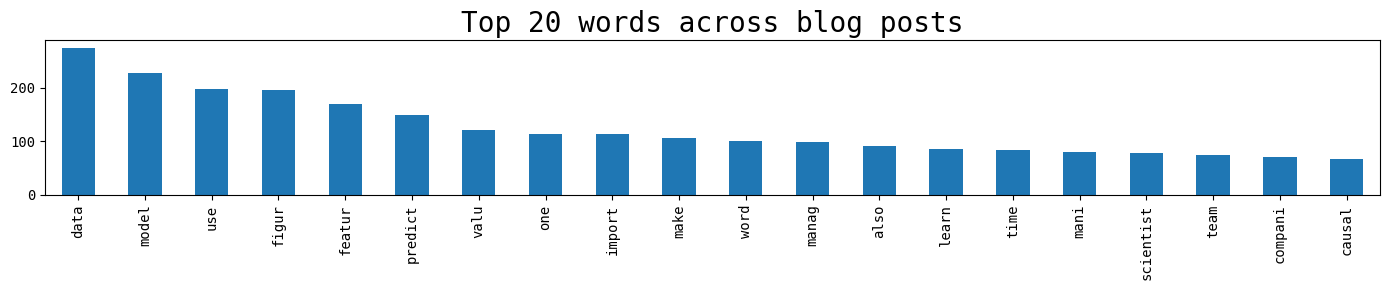

In [8]:
# let's get the top 20 words
fig, ax = plt.subplots(figsize=(14,3))
topk = 20
df_term_mat.sum(axis=1).sort_values(ascending=False).head(topk).plot(kind='bar',ax=ax)
ax.set_title(f'Top {topk} words across blog posts')

In [9]:
def display_scatterplot(embeds, words, method, ax, num_dims=2):
    if method == 'pca':
      # compute PCA
      res = PCA(n_components=num_dims)
      result = res.fit_transform(embeds)
    elif method == 'tsne':
      res = TSNE(n_components=num_dims, random_state=0,
                  perplexity=min(30, len(embeds) - 1))
      result = res.fit_transform(embeds)
    # scatter and annotated plot
    ax.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(words):
        ax.annotate(word, xy=(result[i, 0], result[i, 1]))
    return ax, result

In [10]:
def plot_dim_reduction(df, n_words, label):
  # get top words
  top_words = df.sum(axis=1).sort_values(ascending=False).head(n_words).index
  embeds = df.loc[top_words].values
  words = df.loc[top_words].index
  fig, ax = plt.subplots(1,2, figsize=(16,4))
  _, res_pca = display_scatterplot(embeds, words, method='pca', ax=ax[0])
  ax[0].set_title(f'PCA: {label}')
  _, res_tsne = display_scatterplot(embeds, words, method='tsne', ax=ax[1])
  ax[1].set_title(f'TSNE: {label}')
  return fig, res_pca, res_tsne

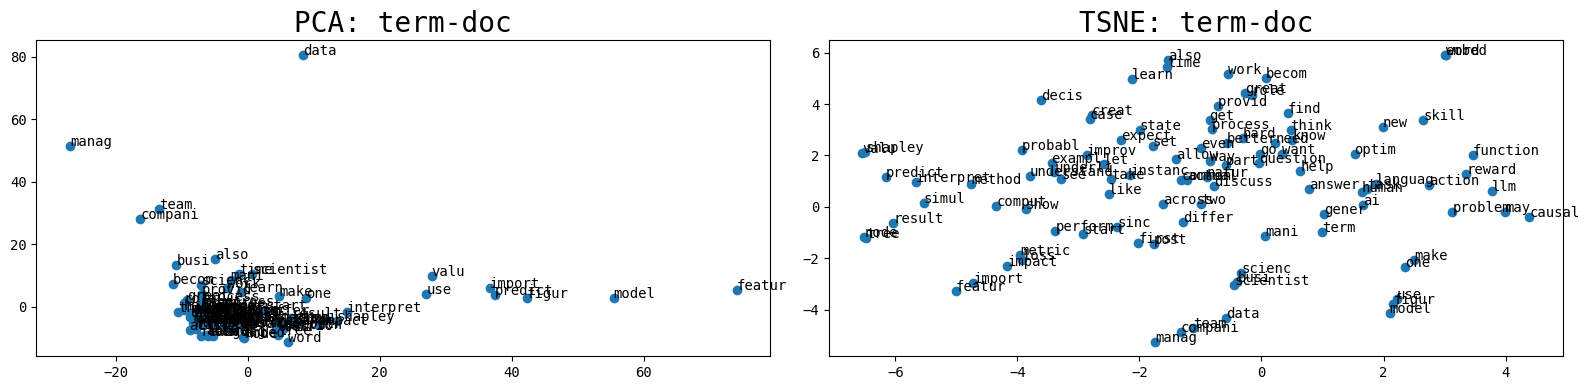

In [11]:
fig,_,_ = plot_dim_reduction(df=df_term_mat, n_words=100, label='term-doc')

In [12]:
def cosine_similarity(word1, word2, embed):
    vec1,vec2 = embed.loc[word1], embed.loc[word2]
    # Compute the dot product of vec1 and vec2
    dot_product = np.dot(vec1, vec2)

    # Compute the L2 norms (Euclidean norms) of vec1 and vec2
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    # Compute the cosine similarity
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)

    return cosine_sim

In [13]:
def find_most_similar(word, embed):
    # Compute the cosine similarity with 'word' for all words in 'embed'
    similarities = {other_word: cosine_similarity(word, other_word, embed) for other_word in embed.index if other_word != word}

    # Find the word that maximizes the cosine similarity
    most_similar_word = max(similarities.keys(), key=(lambda key: similarities[key]))

    return most_similar_word


In [14]:
print('*'*20)
print('Embedding: word-doc matrix')
print('*'*20)
for wrd in ['causal','model','data','predict', 'storytel']:
  best_match = find_most_similar(word=wrd, embed= df_term_mat)
  print(f'Most similar word to {wrd} = {best_match}')


********************
Embedding: word-doc matrix
********************
Most similar word to causal = assumpt
Most similar word to model = show
Most similar word to data = busi
Most similar word to predict = gain
Most similar word to storytel = materi


In [15]:
def extract_sentences(document):
    return nltk.sent_tokenize(document)

extract_sentences(dict_docs[doc_labels[0]])[:2]

['Unsung Heroes: The Vital Role of Managers in Data Teams   TL;DR Why are data managers so important Principles for being a good data manager Hands on: managers have to be strong ICs Transitioning from an IC role to management Hiring managers Introduction In the previous post I discussed which data organization – centralized or decentralized – is better for your company, and mentioned in passing the importance of having a strong management layer.',
 'This is true independently of which org structure you choose, but it’s certainly critical if you decide to build a decentralized team.']

# Let's create a term-term matrix
* We need to fix a context with a window

In [16]:
def create_term_term_matrix(doc_dict, window):
    word_counts = defaultdict(lambda: defaultdict(int))
    for document in doc_dict.keys():
      sentences = extract_sentences(doc_dict[document])
      for sentence in sentences:
          # Remove LaTeX formulas
          sentence = re.sub(r'\$.*?\$', ' ', sentence)
          # Remove punctuation
          sentence = re.sub(r'[^\w\s]', ' ', sentence)
          # Remove numbers
          sentence = re.sub(r'\b\d+\b', ' ', sentence)
          # remove greek lettrs
          sentence = re.sub(r'[^\x00-\x7F]+', ' ', sentence)
          # Remove words that start with a hyphen or an underscore
          sentence = re.sub(r'\b[-_]\w*\b', ' ', sentence)
          words = sentence.split()
          words = [tokenize_and_stem(wrd) for wrd in words if wrd not in stop_words]
          words = [item for sublist in words for item in sublist]
          for i, word in enumerate(words):
              for j in range(max(i-window, 0), min(i+window+1, len(words))):
                  if i != j:
                      word_counts[word][words[j]] += 1

    df = pd.DataFrame(word_counts).fillna(0)
    return df + df.T - np.diag(df.values.diagonal())

In [17]:
tt_mat = create_term_term_matrix(doc_dict=dict_docs, window=6)
print(tt_mat.shape)

(2300, 2300)


In [18]:
#sparsity_pct = 100*((tt_mat == 0).mean().mean())
sparsity_pct = 100*((tt_mat == 0).sum().sum() / (tt_mat.shape[0]*tt_mat.shape[1]))
print(f'Sparcity of term-term matrix = {round(sparsity_pct,2)}%')

Sparcity of term-term matrix = 97.95%


In [19]:
# let's find the words that map to "abil"
target_stem = "abil"
recovered_words = [word for word in terms_clean if stemmer.stem(word) == target_stem]
recovered_words


['abilities', 'ability']

In [20]:
tt_mat.head()

,a,abil,abl,abraham,absenc,absolut,abstract,abund,academ,academia,...,year,yet,yoav,york,you,your,z,zero,ziegler,zoom
a,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abil,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abl,2.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abraham,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absenc,0.0,0.0,0.0,0.0,-11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


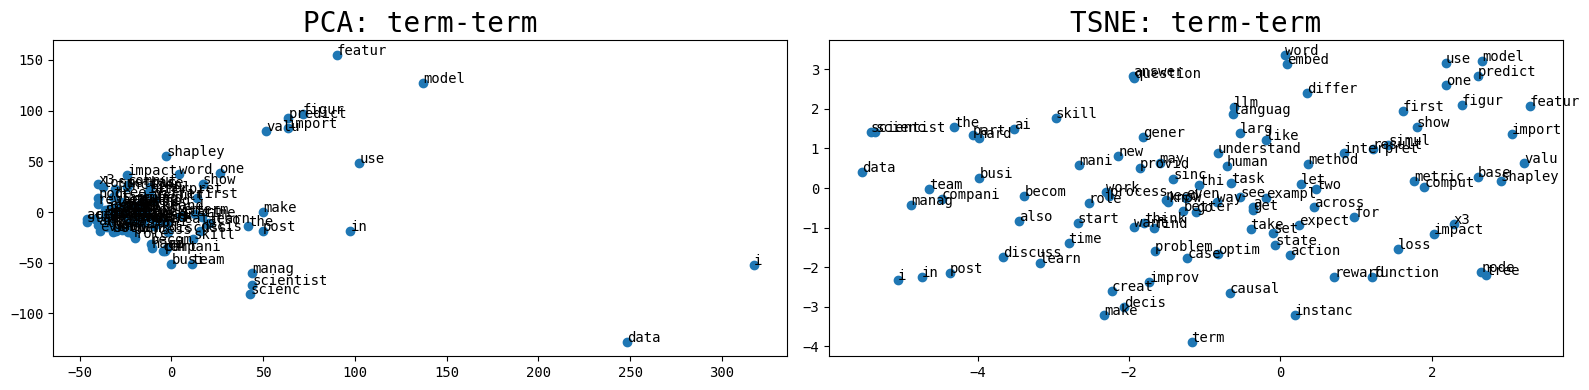

In [21]:
fig,_,_ = plot_dim_reduction(df=tt_mat, n_words=100, label='term-term')

In [22]:
print('*'*20)
print('Embedding: word-word matrix')
print('*'*20)
for wrd in ['causal','model','data','predict', 'storytel']:
  best_match = find_most_similar(word=wrd, embed= tt_mat)
  print(f'Most similar word to {wrd} = {best_match}')


********************
Embedding: word-word matrix
********************
Most similar word to causal = infer
Most similar word to model = one
Most similar word to data = busi
Most similar word to predict = model
Most similar word to storytel = ex


# TF-IDF

$$
\begin{eqnarray}
\text{tf}_{w,d} &=& \log_{10}(\text{count}(t,d) + 1)\\
\text{df}_w &=& \sum_d \mathcal{1}(w \in d)\\
\text{idf}_w &=& \log_{10}(N/\text{df}_w)\\
\text{tf_idf}_{w,d} &=& \text{tf}_{w,d} \times \text{idf}_w
\end{eqnarray}
$$

In [23]:
tf = np.log10(df_term_mat + 1)
dfreq = (df_term_mat>0).sum(axis=1)
idf = np.log10(len(df_term_mat.columns)/dfreq)
tf_idf = tf.multiply(idf, axis=0)
tf_idf.head()

,Managing data teams.docx,feature importance.docx,Should Your Data Team by Centralized or Decentralized.docx,Causality AI and decision making.docx,Feature Importance Measures in Tree-based Ensembles.docx,Opening the Black Box_ The Role of Interpretability in Machine Learning.docx,rlhf_post.docx,How Will Generative AI Change the Practice of Data Science.docx,Data Scientists as Storytellers.docx,ML and decision making.docx,Understanding Emergent Capabilities in GenAI.docx,optimizing decision-making.docx,Confounder bias.docx,understanding embeddings.docx,the story of the book.docx,Interpretable Machine Learning with Shapley Values.docx,interpetability LLMs.docx
data,0.075025,0.060551,0.104599,0.065453,0.000000,0.077806,0.045938,0.068234,0.083248,0.056608,0.032727,0.070721,0.049090,0.051870,0.045938,0.049090,0.000000
model,0.016363,0.088236,0.000000,0.065453,0.070721,0.087667,0.080293,0.054358,0.016363,0.049090,0.081067,0.049090,0.032727,0.065453,0.000000,0.056608,0.016363
use,0.023777,0.030965,0.015852,0.033668,0.029329,0.035345,0.037686,0.025124,0.015852,0.033050,0.025124,0.022251,0.028414,0.039266,0.007926,0.030176,0.000000
figur,0.037994,0.081067,0.025935,0.058662,0.074020,0.071873,0.056608,0.066884,0.037994,0.016363,0.060551,0.032727,0.049090,0.084597,0.000000,0.070721,0.000000
featur,0.000000,0.840067,0.136155,0.000000,0.647402,0.698378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316143,0.000000,0.692684,0.000000


In [24]:
# let's look at words with higher values and 2 that have low values
ix_idf = list(tf_idf.sum(axis=1).sort_values(ascending=False).head(3).index)
ix_idf+=['data','model']
tf_idf.loc[ix_idf]

,Managing data teams.docx,feature importance.docx,Should Your Data Team by Centralized or Decentralized.docx,Causality AI and decision making.docx,Feature Importance Measures in Tree-based Ensembles.docx,Opening the Black Box_ The Role of Interpretability in Machine Learning.docx,rlhf_post.docx,How Will Generative AI Change the Practice of Data Science.docx,Data Scientists as Storytellers.docx,ML and decision making.docx,Understanding Emergent Capabilities in GenAI.docx,optimizing decision-making.docx,Confounder bias.docx,understanding embeddings.docx,the story of the book.docx,Interpretable Machine Learning with Shapley Values.docx,interpetability LLMs.docx
featur,0.000000,0.840067,0.136155,0.000000,0.647402,0.698378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316143,0.000000,0.692684,0.000000
llm,0.000000,0.000000,0.000000,0.474155,0.000000,0.000000,0.385351,0.232004,0.000000,0.441661,0.453208,0.000000,0.000000,0.348007,0.000000,0.000000,0.183859
reward,0.000000,0.000000,0.000000,0.699990,0.000000,0.000000,0.803555,0.000000,0.000000,0.756656,0.000000,0.000000,0.000000,0.189164,0.000000,0.000000,0.000000
data,0.075025,0.060551,0.104599,0.065453,0.000000,0.077806,0.045938,0.068234,0.083248,0.056608,0.032727,0.070721,0.049090,0.051870,0.045938,0.049090,0.000000
model,0.016363,0.088236,0.000000,0.065453,0.070721,0.087667,0.080293,0.054358,0.016363,0.049090,0.081067,0.049090,0.032727,0.065453,0.000000,0.056608,0.016363


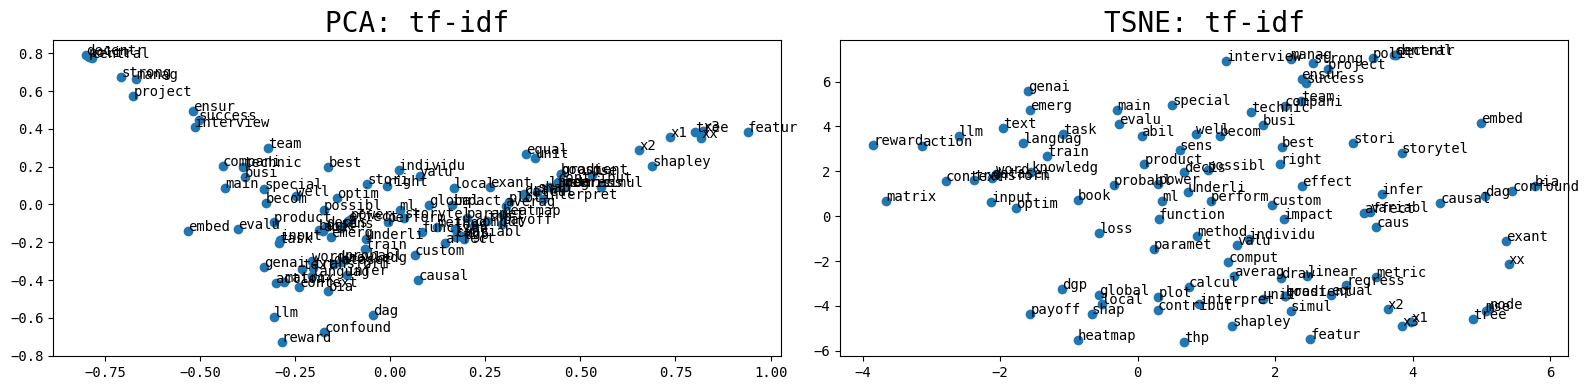

In [25]:
fig,_,_ = plot_dim_reduction(df=tf_idf, n_words=100, label='tf-idf')

# Pointwise Mutual Information (PMI)

For a target word $w$ and a context word $c$:
$$
\begin{eqnarray}
P_{\alpha}(c) &=& \frac{\text{count}(c)^{\alpha}}{\sum_c \text{count}(c)^{\alpha}} \\
PMI_{\alpha}(w,c) &=& \log_2 \left(\frac{P(w,c)}{P(w)P_{\alpha}(c)} \right) \\
PPMI_{\alpha}(w,c) &=& \max\left(PMI_{\alpha}(w,c) ,0\right)
\end{eqnarray}
$$

Here's Jurafsky's notation (chapter 6, equations 6.19)
$$
\begin{eqnarray*}
p_{ij} &=& \frac{f_{ij}}{\sum_{i=1}^{W} \sum_{j=1}^{C} f_{ij}} \\
p_{i*} &=& \frac{\sum_{j=1}^{C} f_{ij}}{\sum_{i=1}^{W}\sum_{j=1}^{C} f_{ij}} \\
p_{*j} &=& \frac{\sum_{i=1}^{W} f_{ij}}{\sum _{i=1 } ^{W}\sum _{j= 1 } ^{C }f _ {ij}}
\end{eqnarray*}
$$

We can use the term-term matrix to compute the PMI and PPMI

In [26]:
def compute_ppmi(df, alpha=1):
    """
    Compute the PPMI matrix
    df: term-term dataframe
    alpha: if not 1, then 0.75
    Taken from Levy, et.al (2015):
    "Improving Distributional Similarity with Lessons Learned from Word Embeddings"
    https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00134/43264/Improving-Distributional-Similarity-with-Lessons
    """
    # Numerator: f[ij]/sum(sum(fij))
    num = df / df.sum().sum()
    # Denominator: independent outcomes
    prob_terms = df.sum(axis=0) / df.sum().sum()
    prob_terms_alpha = np.power(df.sum(axis=0), alpha)  / (df**alpha).sum().sum()
    den = pd.DataFrame(np.outer(prob_terms, prob_terms_alpha), columns=df.columns, index=df.columns)
    # Calculate the PPMI
    ppmi = num / den
    ppmi = ppmi.applymap(lambda x: np.log2(x) if x > 0 else 0)
    ppmi = ppmi.applymap(lambda x: x if x > 0 else 0)

    return ppmi

ppmi = compute_ppmi(df=tt_mat, alpha=0.75)
ppmi.head()

,a,abil,abl,abraham,absenc,absolut,abstract,abund,academ,academia,...,year,yet,yoav,york,you,your,z,zero,ziegler,zoom
a,4.258812,0.000000,3.288338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abil,0.000000,4.349131,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abl,3.567298,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abraham,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absenc,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
wrds_max = ppmi.max(axis=1).sort_values(ascending=False).head(10)
wrds_max = wrds_max.index[::2]
cols = []
for i in range(5):
  cols += list(ppmi.loc[wrds_max[i]].sort_values(ascending=False).index[:3])
ppmi[cols].loc[wrds_max]


,embrac,contrari,on,proven,strategi,list,presid,run,go,s2,run,go,who,us,tri
ignor,14.322659,12.118709,10.961814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
below,0.000000,0.000000,0.000000,13.596343,11.416175,11.001769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.596343,9.990827,8.899772,0.000000,9.990827,8.899772,0.000000,0.000000,0.000000
presid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.990827,8.899772,13.596343,9.990827,8.899772,0.000000,0.000000,0.000000
defraud,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.572659,10.119012,10.047329


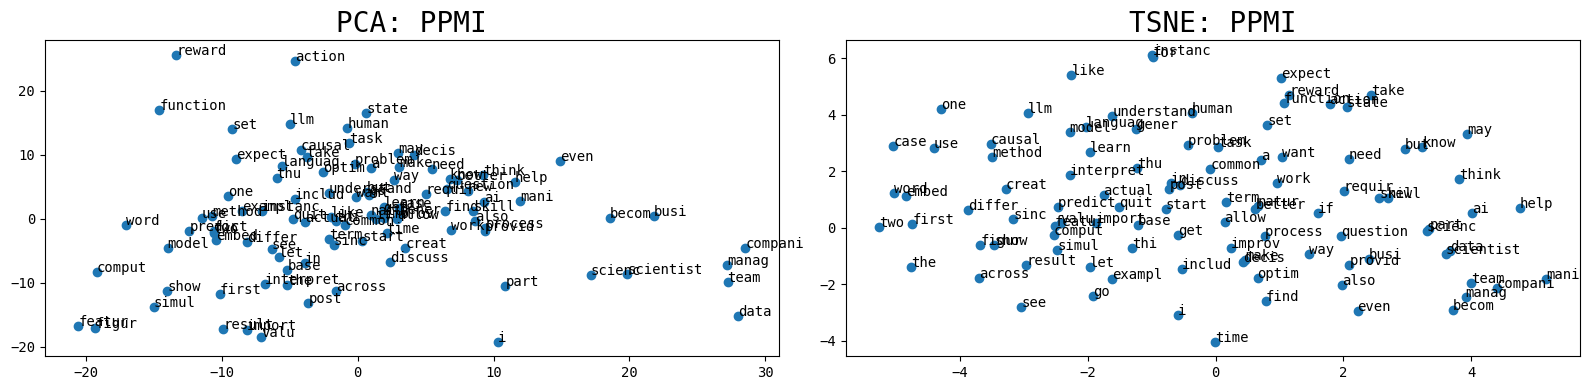

In [28]:
fig,_,_ = plot_dim_reduction(df=ppmi, n_words=100, label='PPMI')

# Let's compute the SVD of PPMI

* I'm following Goldberg (2017), "Neural Network Methods for Natural Language Processing", Chapter. 10

* The use of SVD here is similar in spirit to what we do with recommender systems

* We can "smooth" out the PPMI, getting a denser vector

* Before doing this, we get a sparse matrix.  Presumably, if I incresed the number of blog posts, this matrix would get denser and denser.  

* The SVD allows us to get that denser representation

In [29]:
def compute_svd_mat(df, k=10):
  U, D, VT = np.linalg.svd(df)
  D[k:] = 0  # here I apply the dimensionality reduction
  prodm = np.matmul(U,np.matmul(np.diag(D),VT))
  Mtilde = pd.DataFrame(prodm, index=df.index, columns=df.columns)
  return Mtilde

In [30]:
smoothed_ppmi = compute_svd_mat(df=ppmi, k=10)

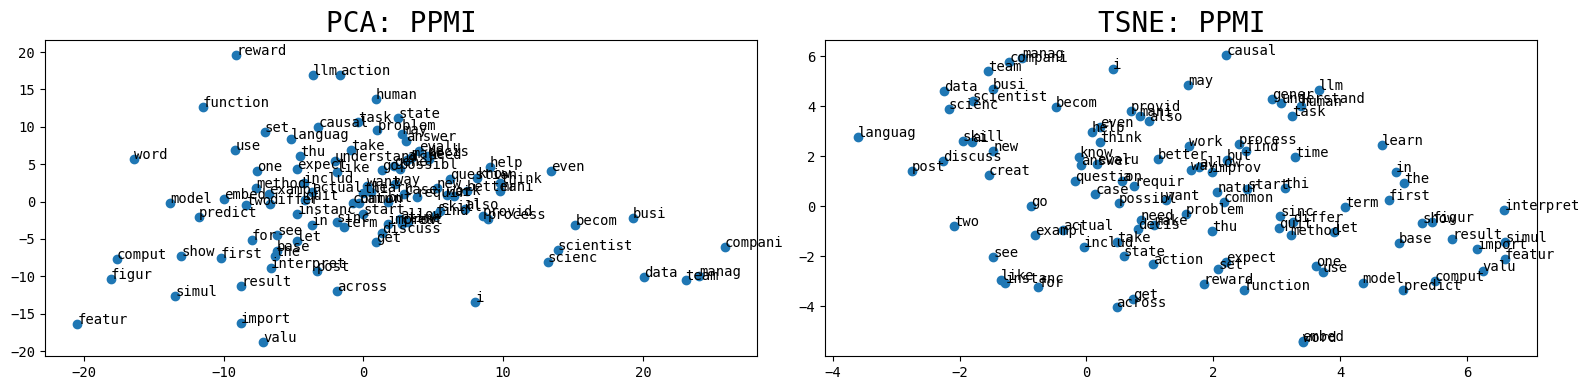

In [31]:
fig,_,_ = plot_dim_reduction(df=smoothed_ppmi, n_words=100, label='PPMI')

# Word2vec & GloVe

* I downloaded `GoogleNews-vectors-negative300.bin` from Kaggle
* We can then use `gensim` to load the pre-trained embeddings
* Alternatively we can just download from `gensim` with `gensim.downloader.load()`

$$
P(D=1 | w, c_{1:k}) = \frac{1}{1+e^{-(w\cdot c_1 + w\cdot c_2 + \cdots + w\cdot c_k)}} \\
\log P(D=1 | w, c_{1:k}) = \sum_i \frac{1}{1+e^{-w\cdot c_i}}
$$

In [32]:
# Uncomment these commands to download the embeddings.
# word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')
# glove_vectors = gensim.downloader.load('glove-twitter-25')

In [33]:
# test by finding the most similar word to "word"
# word2vec_vectors.most_similar('word')

In [34]:
# I use this to find the embeddings for the words in the vocabulary
# If you downloaded the embeddings, uncomment and run
# w2vec = {}
# glove = {}
# for word in terms_clean:
#   try:
#     w2vec[word] = word2vec_vectors[word]
#   except KeyError:
#     a=1
#   try:
#     glove[word] = glove_vectors[word]
#   except KeyError:
#     a=1
# w2vec = pd.DataFrame(w2vec).T
# glove = pd.DataFrame(glove).T

In [35]:
# I have also save these as pickle objects
# w2vec.to_pickle('w2vec.pkl')
# glove.to_pickle('glove.pkl')
w2vec = pd.read_pickle('w2vec.pkl')
glove = pd.read_pickle('glove.pkl')

In [36]:
w2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
automatically,0.026733,-0.242188,0.257812,0.060303,-0.022949,-0.016602,-0.117676,0.150391,0.041748,-0.086914,...,0.108887,0.197266,0.009644,-0.166016,0.136719,0.306641,0.011292,-0.367188,-0.095215,0.101074
systematically,-0.084473,0.241211,0.159180,0.075195,-0.031738,-0.049561,-0.064453,0.161133,0.020874,-0.128906,...,-0.373047,0.198242,-0.125000,0.177734,-0.408203,0.043457,0.088379,0.062500,-0.136719,-0.009216
gave,0.222656,-0.016602,0.134766,-0.133789,0.195312,-0.357422,-0.023682,-0.144531,0.003754,0.255859,...,-0.047119,-0.101074,-0.145508,0.046875,-0.202148,-0.019043,0.046631,-0.185547,0.022583,-0.132812
minimizes,-0.099121,0.113770,-0.275391,-0.113770,-0.106445,0.038330,0.058594,-0.075684,0.224609,-0.052002,...,-0.250000,0.232422,-0.144531,0.257812,-0.302734,0.408203,-0.324219,-0.248047,-0.188477,0.542969
issues,-0.040771,0.251953,-0.215820,0.308594,-0.215820,-0.051514,0.129883,0.006317,0.153320,-0.043701,...,0.051758,-0.125977,0.086426,0.126953,-0.135742,0.193359,-0.079590,-0.202148,0.102051,0.033691


In [37]:
glove.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
automatically,0.12976,0.21516,-0.43766,-0.660870,0.30727,-0.29226,1.043800,-0.99765,-0.75850,0.35939,...,1.396500,0.115500,-0.35021,1.07660,-1.270400,0.62301,-0.85592,0.71433,0.012614,-1.45170
systematically,-0.42264,0.67122,-0.27563,-0.771080,-0.55428,-0.45592,-0.519630,-2.47830,-0.21861,0.23912,...,0.744750,-0.022516,1.39340,1.96160,-1.617100,0.17698,0.57484,-0.68527,-0.812220,-0.66576
gave,-0.34368,0.79519,0.32882,0.497220,-0.29183,-0.74482,0.822580,-0.63426,-0.78830,-0.42204,...,0.039522,0.911470,-0.11820,-0.56634,-0.106480,0.56010,0.54155,0.33414,0.221090,-0.62874
minimizes,-0.63638,-0.17446,-0.71835,0.350880,-0.29979,-0.57654,0.083212,-2.16900,0.96682,-0.96867,...,0.425010,0.859470,0.52051,1.75330,-0.086604,0.34722,0.18537,0.32692,-0.089018,-1.33390
issues,0.48396,0.76482,-1.23490,0.018837,1.06880,-0.44269,0.872550,-1.29680,0.48899,0.46411,...,0.507530,-0.304930,0.55448,0.86721,-0.673220,0.53170,-0.36021,0.25951,-0.258960,-0.89035


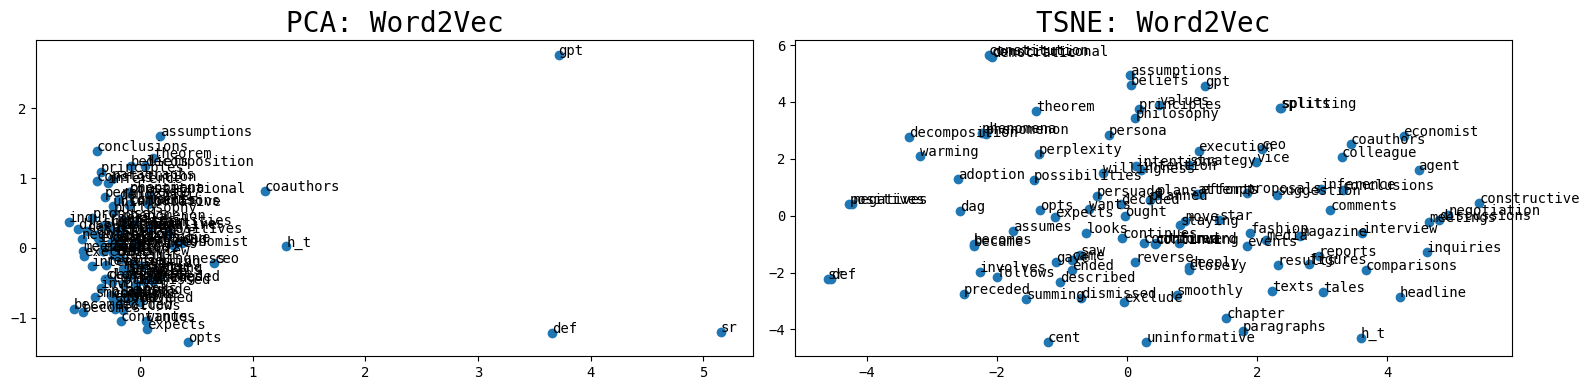

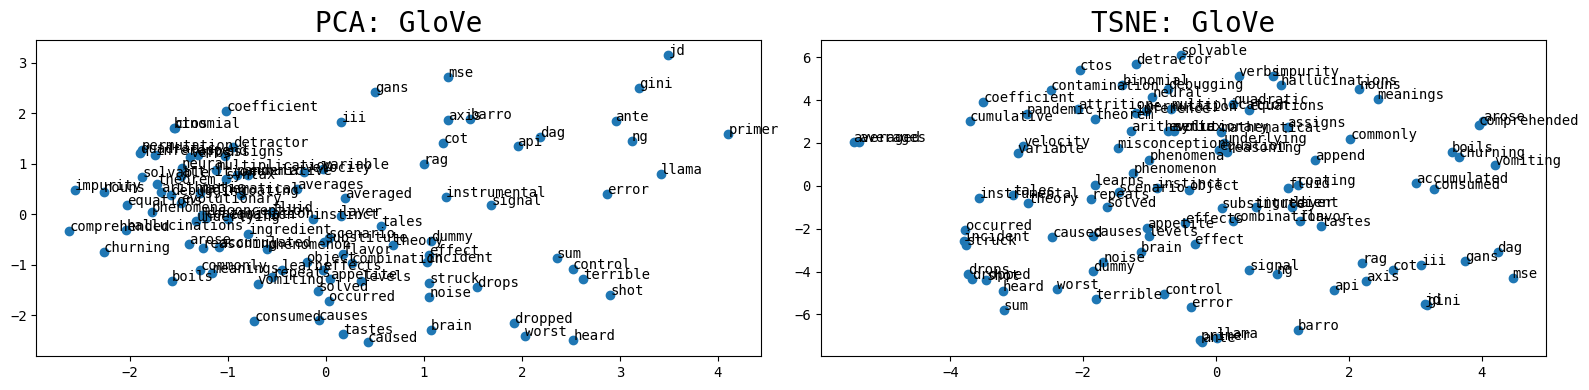

In [38]:
fig,pce_w,tsne_w = plot_dim_reduction(df=w2vec, n_words=100, label='Word2Vec')
fig,pce_g,tsne_g = plot_dim_reduction(df=glove, n_words=100, label='GloVe')

In [39]:
# this cell won't run without the embeddings
# print('*'*20)
# print('Embedding: Word2Vec')
# print('*'*20)
# for wrd in ['causal','model','data','predict', 'storytelling']:
#   best_match = word2vec_vectors.most_similar(wrd)
#   print(f'Most similar word to {wrd} = {best_match}')


In [40]:
# print('*'*20)
# print('Embedding: GloVe')
# print('*'*20)
# for wrd in ['causal','model','data','predict', 'storytelling']:
#   best_match = glove_vectors.most_similar(wrd)
#   print(f'Most similar word to {wrd} = {best_match}')


# Dynamic Embeddings

In [41]:
# let's use bert
model_ckpt = "bert-base-uncased"
model = BertModel.from_pretrained(model_ckpt)
tokenizer = BertTokenizer.from_pretrained(model_ckpt)
input_text = terms_clean
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(input_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (3321 > 512). Running this sequence through the model will result in indexing errors


In [42]:
print(tokenizer.vocab_size, tokenizer.model_max_length)

30522 512


In [43]:
print(len(input_text),len(input_ids), len(tokens))

3321 3321 3321


### Compute embeddings for BERT
We can compute the actual embeddings and the final hiddent stage

In [44]:
embeddings = model.embeddings.word_embeddings.weight[input_ids].squeeze(0).detach().numpy()
emb_bert = pd.DataFrame(embeddings, index=input_text)
emb_bert.head()
run_embed = emb_bert.loc['run'] # static embedding for "run"

In [45]:
# let's use the word "run" in two contexts:
sentence1 = "I am going to run a marathon"
sentence2 = "I am going to run for president"
sentence3 = "I am going to run a python script"

In [46]:
def get_context_embeddings_bert(text, target_word):
  input_ids = tokenizer.encode(text, add_special_tokens=True)
  tokens = tokenizer.convert_ids_to_tokens(input_ids)
  id_target = range(len(input_ids))[input_ids=='target_word']
  input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
  # run a forward pass to make a prediction, and get the last hidden state
  with torch.no_grad():
      outputs = model(input_ids)
      hidden_state = outputs.last_hidden_state
  hidden_state = hidden_state.squeeze(0).detach().numpy()
  hs_target = hidden_state[id_target,:]  # I only care about the target word

  return hs_target



In [47]:
# tet static and contextual embeddings
t1 = get_context_embeddings_bert(sentence1,'run')
t2 = get_context_embeddings_bert(sentence2,'run')
t3 = get_context_embeddings_bert(sentence3,'run')
df_run =pd.DataFrame({'run: static':run_embed.values,
              'run: sentence 1':t1,
              'run: sentence 2':t2,
              'run: sentence 3':t3,})


In [48]:
print(len(t1))
df_run.head(10).T

768


,0,1,2,3,4,5,6,7,8,9
run: static,0.043627,-0.003231,-0.003812,-0.014065,0.024662,0.049499,-0.035453,-0.001271,-0.074099,-0.031579
run: sentence 1,0.012839,0.419089,0.073610,-0.372856,-0.561582,-0.560968,0.444074,0.580267,0.001900,-0.348836
run: sentence 2,0.024832,0.163939,0.103220,-0.235542,-0.234028,-0.542008,0.206127,0.703490,-0.045391,-0.375095
run: sentence 3,0.113448,0.172789,-0.083000,-0.375832,-0.239429,-0.395050,0.313126,0.721715,-0.008944,-0.232750


Text(0.5, 1.0, "First two principal components: 'run'")

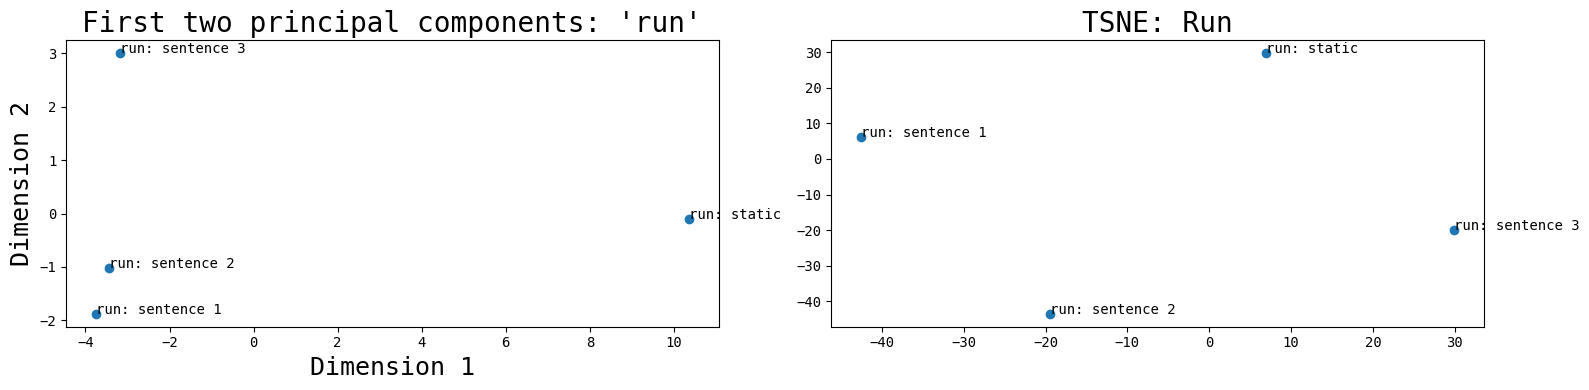

In [49]:
fig,pce_run,tsne_run = plot_dim_reduction(df=df_run.T, n_words=100, label='Run')
ax = fig.get_axes()
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].set_title("First two principal components: 'run'")

In [50]:
# let's compute the similarity for all
norms = df_run.apply(lambda x: np.linalg.norm(x))
cross_prod = pd.DataFrame(np.dot(df_run.T, df_run))
norms

run: static         1.125760
run: sentence 1    14.329212
run: sentence 2    14.023736
run: sentence 3    13.819783
dtype: float32